# RCS Calculation with Ray Tracing

This is an example of using `RadarSimPy` to get the radar cross section (RCS) of a 3-D object model. Ray-Tracing/Shoot-and-Bounce-Rays method is used in `RadarSimPy`. The ray-tracing engine `RadarSimC`, which is built with C++, is integrated in RadarSimPy.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

---

## Example with a corner reflector

The corner reflector model is with `.stl`. It can be imported by using `numpy-stl` module. 

In [1]:
import time

import numpy as np
from stl import mesh
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

---

The RCS calculation function is `rcs_sbr`

In [2]:
from radarsimpy.rt import rcs_sbr

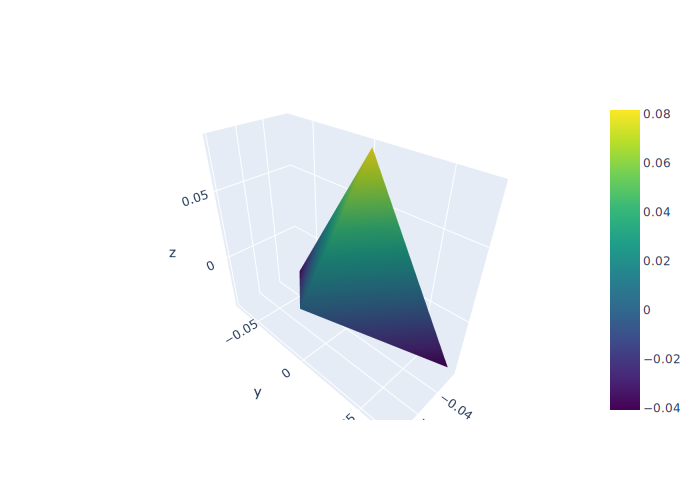

In [3]:
mesh_data = mesh.Mesh.from_file('../models/cr.stl')

x = np.ravel(mesh_data.vectors[:, :, 0])
y = np.ravel(mesh_data.vectors[:, :, 1])
z = np.ravel(mesh_data.vectors[:, :, 2])

cr = go.Mesh3d(x=x, y=y, z=z, opacity=1,
               i=np.arange(0, np.shape(mesh_data.vectors)[0]*3, 3),
               j=np.arange(1, np.shape(mesh_data.vectors)[0]*3, 3),
               k=np.arange(2, np.shape(mesh_data.vectors)[0]*3, 3),
               intensity=z, colorscale='Viridis'
               )

fig = go.Figure(data=[cr])
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

---

### RCS vs frequency

Define the basic parameters required in ray tracing.

- Observation angle `phi` (Degree)
- Observation angle `theta` (Degree)
- Frequency `freq` (Hz)
- Polarization `pol`
- Ray density `density` (number of rays per wavelength)

In [4]:
phi = 0
theta = 90
freq = np.arange(1, 79, 1)*1e9
pol = [0, 1, 0]
density = 10

rcs = np.zeros_like(freq)

tic = time.time()
for f_idx, f in enumerate(freq):
    rcs[f_idx] = 10*np.log10(rcs_sbr('../models/cr.stl', f, phi,
                                     theta, pol=pol, density=density))
toc = time.time()

In [5]:
print('Execution time:', toc-tic, 's')

Execution time: 14.05994725227356 s


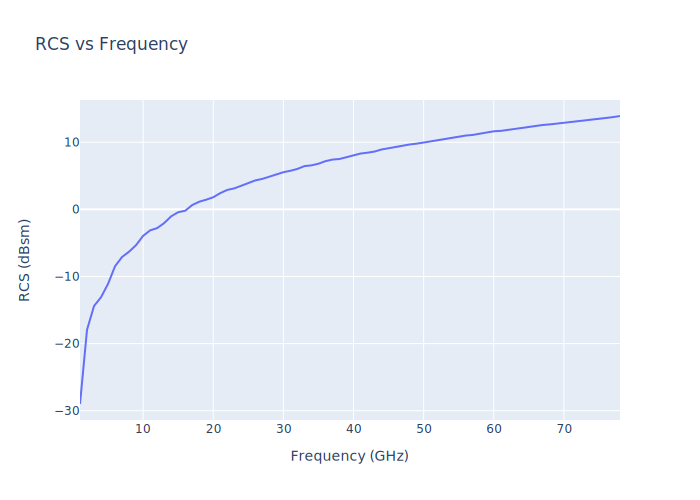

In [6]:
data = go.Scatter(x=freq/1e9, y=rcs)

layout = go.Layout(
    title='RCS vs Frequency',
    yaxis=dict(title='RCS (dBsm)'),
    xaxis=dict(title='Frequency (GHz)'),
)
fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

### RCS vs observation angle

In [7]:
phi = np.arange(-90, 90, 0.5)
theta = 90
freq = 77e9
pol = [0, 0, 1]
density = 1

rcs = np.zeros_like(phi)

tic = time.time()
for phi_idx, phi_ang in enumerate(phi):
    rcs[phi_idx] = 10 * \
        np.log10(rcs_sbr('../models/cr.stl', freq, phi_ang,
                         theta, pol=pol, density=density))
toc = time.time()

In [8]:
print('Execution time:', toc-tic, 's')

Execution time: 2.6581978797912598 s


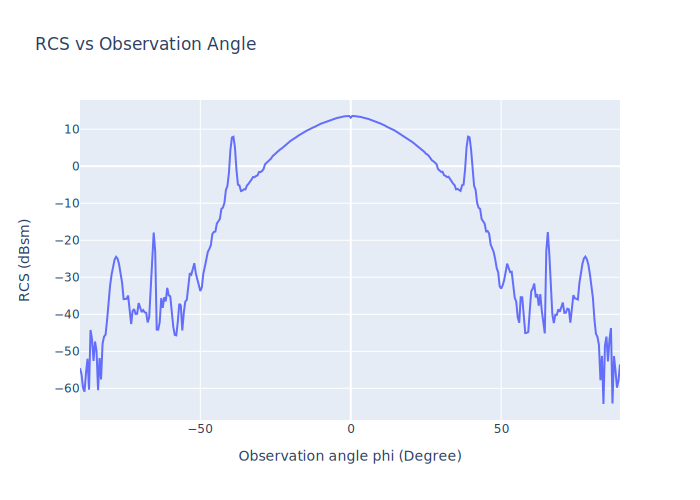

In [9]:
data = go.Scatter(x=phi, y=rcs)

layout = go.Layout(
    title='RCS vs Observation Angle',
    yaxis=dict(title='RCS (dBsm)'),
    xaxis=dict(title='Observation angle phi (Degree)'),
)
fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))